On google notebook, nice info:
https://medium.com/google-cloud/using-google-cloud-ai-platform-notebooks-as-a-web-based-python-ide-e729e0dc6eed


Understading pytorch:
https://towardsdatascience.com/understanding-pytorch-with-an-example-a-step-by-step-tutorial-81fc5f8c4e8e

In [2]:
import numpy as np
import torch.nn as nn
import torch
from torch import optim
from torch.utils.data import DataLoader, Dataset
import torchvision
import pixiedust # visual debugger
from collections import OrderedDict
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter  # For connectivity to Tensordboard API
from torchvision import transforms
import matplotlib.pyplot as plt
from pprint import pprint

#set_env just drop braeakpoint() in code to debug (python 3.7).
%set_env PYTHONBREAKPOINT=IPython.core.debugger.set_trace 

%load_ext autoreload
%autoreload 2
%matplotlib inline

dev = "cuda:0" if torch.cuda.is_available() else "cpu"
print("Running code on:", dev)
version = torch.__version__
assert version == "1.1.0"
print("Torch version", torch.__version__)

Pixiedust database opened successfully


ImportError: TensorBoard logging requires TensorBoard with Python summary writer installed. This should be available in 1.14 or above.

High level API for pytorch

Made some library called Poutyne which is basically a PyTorch front-end with a Keras-like interface. What is nice about it is the callbacks that comes with it and that you can make your own callbacks. No more need to make/copy-paste your training loop for each new project.
Pytoune https://nodata.science/no-fit-comparing-high-level-learning-interfaces-for-pytorch.html


Fast.ai


imgaug is a personal favorite for image data augmentation. Works well with bounding boxes and segmentation maps and offers a lot of different image manipulation options.
xarray It's like pandas, but for N-dimensional data.

I used it for storing 10 dimensional tensors created by performing an extensive grid search. Each axis could be labelled by the hyperparameter name and indexed by the tested values.

Code example to use device definition:
```python
z = torch.randn((2,2), device=dev)
y = torch.randn((2,2)).to(z.device)
```

https://stackoverflow.com/questions/49643225/whats-the-difference-between-reshape-and-view-in-pytorch

torch.view has existed for a long time. It will return a tensor with the new shape. The returned tensor will share the underling data with the original tensor. See the documentation here.

On the other hand, it seems that torch.reshape has been introduced recently in version 0.4. According to the document, this method will

    Returns a tensor with the same data and number of elements as input, but with the specified shape. When possible, the returned tensor will be a view of input. Otherwise, it will be a copy. Contiguous inputs and inputs with compatible strides can be reshaped without copying, but you should not depend on the copying vs. viewing behavior.

It means that torch.reshape may return a copy or a view of the original tensor. You can not count on that to return a view or a copy. According to the developer:

    if you need a copy use clone() if you need the same storage use view(). The semantics of reshape() are that it may or may not share the storage and you don't know beforehand.

Another difference is that reshape() can operate on both contiguous and non-contiguous tensor while view() can only operate on contiguous tensor. Also see here about the meaning of contiguous.

In [6]:
def mem_status():
    dev = "cuda:0" if torch.cuda.is_available() else "cpu"
    if dev != "cpu":
        mem_total = torch.cuda.get_device_properties(dev).total_memory / 1e9
        mem_used = torch.cuda.max_memory_allocated() / 1e9
        mem_frac = mem_used / mem_total * 100
        print("GPU memory used {:.2f}GB i.e. {:.1f}% out of {:.0f}GB".format(mem_used, mem_frac, mem_total))
    else: print("GPU not present")
mem_status()

GPU not present


In [45]:
final_module_list = nn.ModuleList()

a_sequential_module_with_names = nn.Sequential(OrderedDict([
        ('dropout1', nn.Dropout(0.1)),
        ('dense1', nn.Linear(10, 10)),
        ('tanh', nn.Tanh()),
        ('dropout2', nn.Dropout(0.1)),
        ('dense2', nn.Linear(10, 10)),
        ('tanh', nn.Tanh()),
        ('dropout3', nn.Dropout(0.1)),
        ('dense3', nn.Linear(10, 10))]))

final_module_list.add_module('Stage 1', a_sequential_module_with_names)
final_module_list.add_module('Stage 2', a_sequential_module_with_names)
final_module_list

ModuleList(
  (Stage 1): Sequential(
    (dropout1): Dropout(p=0.1)
    (dense1): Linear(in_features=10, out_features=10, bias=True)
    (tanh): Tanh()
    (dropout2): Dropout(p=0.1)
    (dense2): Linear(in_features=10, out_features=10, bias=True)
    (dropout3): Dropout(p=0.1)
    (dense3): Linear(in_features=10, out_features=10, bias=True)
  )
  (Stage 2): Sequential(
    (dropout1): Dropout(p=0.1)
    (dense1): Linear(in_features=10, out_features=10, bias=True)
    (tanh): Tanh()
    (dropout2): Dropout(p=0.1)
    (dense2): Linear(in_features=10, out_features=10, bias=True)
    (dropout3): Dropout(p=0.1)
    (dense3): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [56]:
list(dict(dict(final_module_list.named_children())["Stage 1"].named_children()).keys()).index("tanh")

2

In [77]:
class SimpleModule(nn.Module):
    def __init__(self, in_c, n_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(4608, 1024)
        self.fc2 = nn.Linear(1024, n_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = x.view(x.size(0), -1) # flat   
        x = self.fc1(x)
        x = torch.sigmoid(x)
        x = self.fc2(x)
        
        return x

model = SimpleModule(1, 10)
model(torch.randn((3, 1, 12, 12)))

tensor([[ 0.1626,  0.0186, -0.1295,  0.4807,  0.3269, -0.2481, -0.3786, -0.0067,
         -0.3329, -0.0407],
        [ 0.1094,  0.0186, -0.1655,  0.4677,  0.3674, -0.2741, -0.3422,  0.0105,
         -0.3493, -0.0011],
        [ 0.1324,  0.0235, -0.1276,  0.4514,  0.3300, -0.2560, -0.3444, -0.0085,
         -0.3310,  0.0424]], grad_fn=<AddmmBackward>)

In [79]:
class ModuleWithSequence(nn.Module):
    def __init__(self, in_c, n_classes):
        super().__init__()
        
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_c, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        
    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = x.view(x.size(0), -1) 
        
        return x

model = ModuleWithSequence(1, 10)
model(torch.randn((3, 1, 12, 12)))

tensor([[0.0000, 0.0000, 0.1861,  ..., 0.0285, 0.6225, 0.3746],
        [0.0000, 0.0000, 0.0674,  ..., 0.0000, 0.0000, 0.0000],
        [0.2947, 0.0675, 0.0000,  ..., 0.1377, 0.3450, 0.1012]],
       grad_fn=<ViewBackward>)

In [92]:
x = torch.from_numpy(np.ones(1))
x.requires_grad = True
def poly(x):
    #set_trace()
    return x**2 + 4 * x + 6
print(x)
grad_x = torch.autograd.grad(poly(x), x)
print(grad_x)

tensor([1.], dtype=torch.float64, requires_grad=True)
(tensor([6.], dtype=torch.float64),)


# Model evaluation
for evaluation of model use:
```python
model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
with torch.no_grad(): #enables context manager, which removes grads for testing (improves memeory and CPU time)
```

In [119]:
print(poly(x).requires_grad)
with torch.no_grad(): #enables context manager, which removes grads for testing (improves memeory and CPU time)
    print(poly(x).requires_grad)

True
False


In [100]:
print(x.shape)
print(x)
print(x+1)
print(x.add(1))

torch.Size([1])
tensor([1.], dtype=torch.float64, requires_grad=True)
tensor([2.], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([2.], dtype=torch.float64, grad_fn=<AddBackward0>)


In [105]:
#inplace
b = torch.tensor([3.])
b+=1
print(b)
b.add_(1)
print(b)

tensor([4.])
tensor([5.])


In [144]:
def plot_fit(title, model):
    plt.tilte = title
    w1, b1 = get_params(model)
    x1 = np.array([-30, 30])
    y1 = w1 * x1 + b1
    plt.plot(x1, y1, "r")
    plt.scatter(X, y)

In [151]:
def zero_parameters(model):
    for param in model.parameters():
        param.data *= 0
        
def get_params(model):
    w, b = model.parameters()
    return w[0,0].item(), b[0].item()
get_params(model)

def reset(m):
    #Usage: model_to_reset.apply(reset)
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()

(0.5152631998062134, -0.44137823581695557)

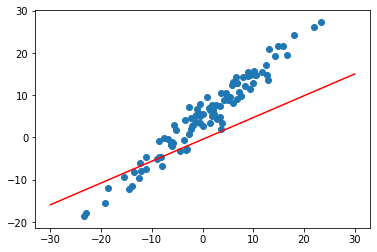

In [174]:
torch.manual_seed(1) # random seed init. Must be at cell?
class LR(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)
    
    def forward(self, x):
        pred = self.linear(x)
        return pred
model = LR(input_size=1, output_size=1).to(dev) # Model deplyed to "dev" deivice
get_params(model)
plot_fit("init fit", model)

In [182]:
#Optimization
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

zero_parameters(model)  # otherwize it further optimizes model's parameters
epoch = 10
losses = []

X, y = X.to(dev), y.to(dev) # Make sure that data is also transfered to device
model.train()
optimizer.zero_grad()

for i in range(epoch):
    y_pred = model.forward(X)
    loss = criterion(y_pred, y)
    losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

#Model evaluation on evaluation data most commonly
model.eval()
with torch.no_grad():
    y_pred_final = model.forward(torch.tensor([1.0]))
print(y_pred_final)

tensor([1.8180])


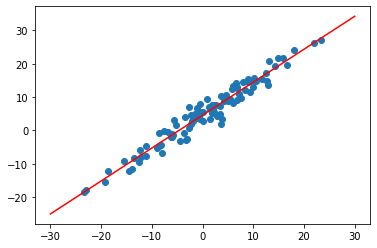

In [170]:
plot_fit("trained", model)

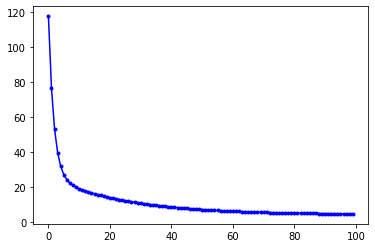

In [165]:
plt.plot(range(epoch), losses, ".b-");

## Data processing:

* Transforms
* Dataset
* DataLoader
* Sampler

In [190]:
class DataSetExample(Dataset):
    def __init__(self):
        super().__init__()
        # TODO implement me
    
    def __len__(self):
        # TODO implement me
        pass
    
    def __getitem__(self, idx):
        # TODO implement me
        pass
dataset = DataSetExample()
dataset

In [191]:
def get_trainable(model_params):
    return (p for p in model_params if p.requires_grad)

def get_frozen(model_params):
    return (p for p in model_params if not p.requires_grad)

def all_trainable(model_params):
    return all(p.requires_grad for p in model_params)

def all_frozen(model_params):
    return all(not p.requires_grad for p in model_params)

def freeze_all(model_params):
    for param in model_params:
        param.requires_grad = False

In [ ]:
#Transformations DataSets and DataLoaders
_image_size = 224
_mean = [0.485, 0.456, 0.406]
_std = [0.229, 0.224, 0.225]

train_trans = transforms.Compose([
    transforms.Resize(256),  # some images are pretty small
    transforms.RandomCrop(_image_size),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(.3, .3, .3),
    transforms.ToTensor(),
    transforms.Normalize(_mean, _std),
])
val_trans = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(_image_size),
    transforms.ToTensor(),
    transforms.Normalize(_mean, _std),
])

train_ds = DogsCatsDataset("../data/raw", "sample/train", transform=train_trans)
val_ds = DogsCatsDataset("../data/raw", "sample/valid", transform=val_trans)

batch_size = 2
n_classes = 2

train_dl = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
)
val_dl = DataLoader(
    val_ds,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
)